# Dogs Breed Classification 

In this Research we will try to build a Convolutional neural network that recognizes a dog's breed in a picture.

After fine tuning and looking for appropriate architecture considering the used below metrics, loss functions and also time consumption, we decided to stick to the simplest form of Transfer Learning. Right after the pre-trained Inception-Resnet model and it's convolutional layers we will finish with fully connected layer of our own that will serve directly to classify the breed.

The architecture is simple but the hyperparameters got changed drastically from the default ones. As you'll see we lowered the learning rate to 1e-5, we increased the mini batches to 64 but we kept the Adam optimizer as it didn't display significantly different results from SGD and Rmsprop.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input , Dense, Flatten, Dropout, Conv2D, MaxPool2D

from tensorflow.keras.applications import resnet_v2, inception_resnet_v2

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

## Download and preprocess the data

We'll use the Tensorflow API to download and preprocess the dataset.

In [129]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

One quick check of what we got.

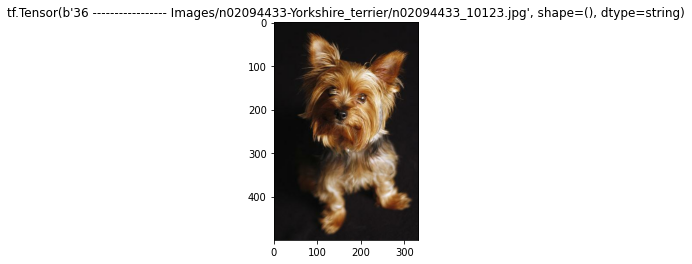

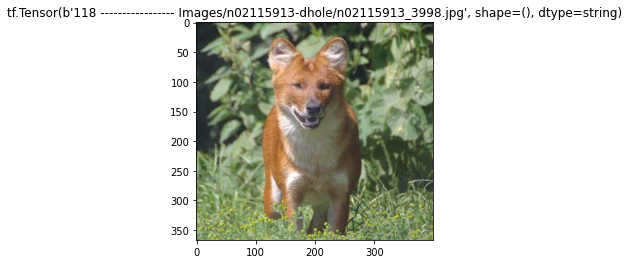

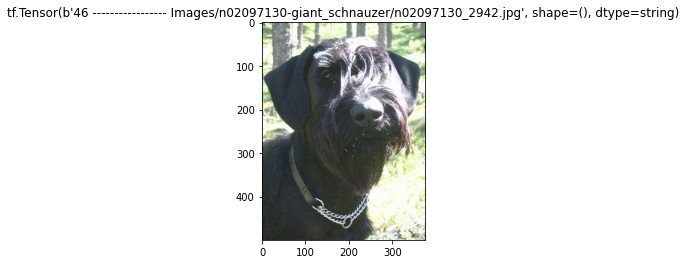

In [130]:
for x in dataset['train'].take(3):
  plt.imshow(x['image'])
  plt.title(str(x['label'].numpy()) + " ----------------- "+  x['image/filename'])
  plt.show()

## Prepare Transfer Learning and Image processing.

In [131]:
resnet_inception = inception_resnet_v2.InceptionResNetV2()

In [ ]:
#resnet_inception.summary()

In [132]:
len(resnet_inception.layers)

782

In [133]:
IMG_LEN = 299
IMG_SHAPE = (IMG_LEN, IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

Resnet Inception as you saw is a huge model and we will need to change only the last layer. We are going to make it work for our dataset. We will remain with the pre-trained weights of the convolutional layers from Image-net because the Stanford Dogs Dataset is created by the same source anyway, so it should be good.

In [134]:
resnet_inception = Model(inputs = resnet_inception.layers[0].input, outputs = resnet_inception.layers[780].output)

In [135]:
for layer in resnet_inception.layers:
  layer.trainable = False

By adding augmentation layer we flip, rotate and zoom the pictures. Not only do we create more data, we also make the model learn harder different positions and features.

In [136]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(299, 
                                                              299,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Training

The tuning process has been performed in different folder. Here we will train our model with its final hyperparameters.

In [137]:
resnet_inception = Sequential([
                           data_augmentation,
                           resnet_inception,
                           Dense(N_BREEDS, activation = 'softmax')
])

We add only one Dense Layer with 120 units to classify for our dataset. The ResnetInception convolutional layers are the huge part of it and we don't need to overkill the process with even more fully conected layers. It's not necessary.

In [138]:
resnet_inception.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy', TopKCategoricalAccuracy(k=3)])

The Adam optimizer works well, the Learning rate is significantly lower than the default one but here we'll only have one final model so we should give it all and for loss we use the categorical cross entropy which is a standard for classification with more labels and the metrics we care about are accuracy and TopKCategoricalAccuracy. The final one is a bit more interesting so let's explain it.

The dataset is hard even for humans. Some of the breeds are very much alike. This is why having this metrics as high as possible is important. We might not be able to tell the difference between Belgian Malinois and German Shepherd but we must for sure conclude it's one of them.

In [139]:
train_batches = prepare(training_data, batch_size=64)
test_batches = prepare(test_data, batch_size=64)

Prepare the dataset. Let's also have Early stopping based on Validation loss. If it doesn't improve/decline for three straight epochs, we will stop the process.

In [140]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [141]:
history_resnet_inception = resnet_inception.fit(train_batches, validation_data=test_batches,  epochs = 50, callbacks = [early_stopping])

Epoch 1/50
188/188 [==============================] - 135s 656ms/step - loss: 4.8711 - accuracy: 0.0113 - top_k_categorical_accuracy: 0.0328 - val_loss: 4.7117 - val_accuracy: 0.0312 - val_top_k_categorical_accuracy: 0.0756
Epoch 2/50
188/188 [==============================] - 124s 640ms/step - loss: 4.6684 - accuracy: 0.0402 - top_k_categorical_accuracy: 0.0878 - val_loss: 4.5136 - val_accuracy: 0.0887 - val_top_k_categorical_accuracy: 0.1619
Epoch 3/50
188/188 [==============================] - 123s 639ms/step - loss: 4.4784 - accuracy: 0.0997 - top_k_categorical_accuracy: 0.1882 - val_loss: 4.3209 - val_accuracy: 0.1713 - val_top_k_categorical_accuracy: 0.3099
Epoch 4/50
188/188 [==============================] - 124s 639ms/step - loss: 4.2864 - accuracy: 0.1860 - top_k_categorical_accuracy: 0.3402 - val_loss: 4.1329 - val_accuracy: 0.3016 - val_top_k_categorical_accuracy: 0.4909
Epoch 5/50
188/188 [==============================] - 123s 638ms/step - loss: 4.1125 - accuracy: 0.3142 

## Examine the results

We could have used Tensorboard but for the purposes of this report we will do the EDA ourselves here on place. A simple plotting function will do just fine.

In [182]:
def plot_train_and_validation_results(train, validation, title, epochs_range):
  plt.figure(figsize=[6,4])
  plt.plot(train)
  plt.plot(validation)
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  if epochs_range:
    plt.xticks(epochs_range)
  plt.title(title)
  plt.legend(['Training', 'Validation'])
  plt.show()

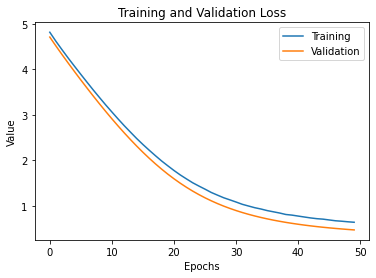

In [183]:
plot_train_and_validation_results(history_resnet_inception.history['loss'], history_resnet_inception.history['val_loss'], 'Training and Validation Loss', range(0, 51, 10) )

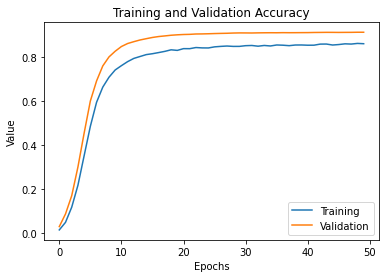

In [173]:
plot_train_and_validation_results(history_resnet_inception.history['accuracy'], history_resnet_inception.history['val_accuracy'], 'Training and Validation Accuracy', range(0, 51, 10)  )

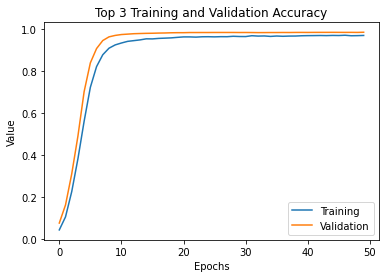

In [174]:
plot_train_and_validation_results(history_resnet_inception.history['top_k_categorical_accuracy'], history_resnet_inception.history['val_top_k_categorical_accuracy'], 'Top 3 Training and Validation Accuracy',  range(0, 51, 10)  )

### Problems
First things first. Surprisingly or not we've got better performance on validation data. We need to adress that. Is it overfitting, leak, bad distribution or simply easier observations? 

First of all the margin is insignificant and the gap is constantly shrinking with time. Second, the distribution is fine. Yes, the dataset is not perfectly balanced but its close to that state. Third, the proportions of this Tensorflow Dataset train-validation split is very unusual, also we evaluate after an epoch of training over huge validation number so it is supposed to be better. Last but not least, the learning graphics look perfectly fine.

### Scores
Let's analyze the results now. Based on both Training and Validation data we should expect between 85%(training) and 91.5%(validation) accuracy with one guess. The metrics Val Top K Accuracy that we set up to look for the top 3 classes is even greater with between 97-98.5% score. In other words there is around 91% chance our model to recognize the label instantly and around 98% to put the correct label in a sample of 2 other labels.


### Learning Graphics

Based on the last two graphics we could have stopped the model earlier. The Accuracy and  Top K Accuracy didn't improve much from epoch 15 to epoch 50. But they were going up slowly still.  And most importantly the Loss curve looks great. Even though the other two kind of stagnated, the loss learning curve kept getting deeper. Based on the tuning process and the final few epochs it slowed down a bit but the model was still learning and the stagnation of the other two metrics is result of the very hard and relatively small dataset. 

Conclusion - the model was learning and it will continue to learn for at least  few more epochs if we decide to continue or even add more data.

## Test it with URLs from Internet

In [146]:
from skimage.io import imread
from skimage.transform import resize

In [147]:
image = imread('https://epi.azureedge.net/website-images/images/default-album/yorkshire-terrierdf23b6a24c9f653bbdf5ff0000035de2.jpg?sfvrsn=64bcd37b_2')

Let's try it with one of the most difficult classes as described in the data source. This buddy on the picture is a Yorkshire terrier.

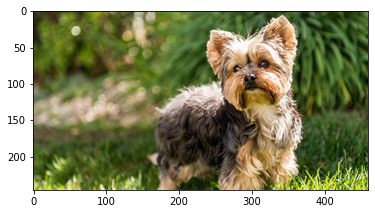

In [148]:
plt.imshow(image)
plt.show()

We are going to test with several pictures so let's make a function so we don't repeat code unnecessarily.

In [205]:
def name_the_breed(raw_picture, model, named_labels):
  picture = resize(raw_picture, (299, 299), preserve_range = True)
  picture = tf.keras.applications.inception_resnet_v2.preprocess_input(picture)
  picture = tf.expand_dims(picture, axis = 0)
  predictions = model.predict(picture)
  prediction = max(predictions[0])
  index = list(predictions[0]).index(prediction)
  score = f'This is a {named_labels[index]} with {round((100 * prediction), 2)} % certainty'
  return  score


In [150]:
import pickle

In [151]:
# This is a dictionary that I created in order to get names not raw numbers.

dictionary = open('drive/MyDrive/dict_of_labels.pickle', 'rb')
named_labels = pickle.load(dictionary)
dictionary.close()

In [152]:
print(name_the_breed(image, resnet_inception, named_labels=named_labels))

This is a Yorkshire_terrier with 76.16 % certainty


We are gonna test it with German Shepherd now.

In [153]:
image2 = imread('https://kc-media-cdn-live.azureedge.net/cache/a/3/b/3/8/2/a3b382340f57e8d45582a14a9dffc701cf061f7e.jpg')

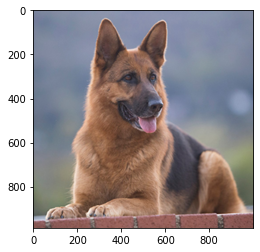

In [154]:
plt.imshow(image2)
plt.show()

In [155]:
print(name_the_breed(image2, resnet_inception, named_labels=named_labels))

This is a German_shepherd with 78.46 % certainty


Another one that pops in my mind is Tibetan Mastif. Let's try it.

In [156]:
image3 = imread('https://images.saymedia-content.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTc2MjkyMzMzODU1MTg4MTU4/tibetan-mastiffs-ancestors-of-10-new-dog-breeds.jpg')

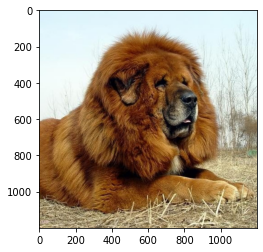

In [157]:
plt.imshow(image3)
plt.show()

In [158]:
print(name_the_breed(image3, resnet_inception, named_labels=named_labels))

This is a Tibetan_mastiff with 85.33 % certainty


In [159]:
image4 = imread('https://www.purelypetsinsurance.co.uk/media/1284/poodle-1.jpg')

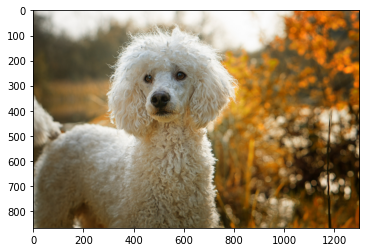

In [160]:
plt.imshow(image4)
plt.show()

In [161]:
print(name_the_breed(image4, resnet_inception, named_labels=named_labels))

This is a standard_poodle with 50.81 % certainty


As we can see the model guessed correctly all the four pictures we gave it to it. But it's not the most certain one. We interrupted the model while the loss was still going down so we can freely and easily go for few more rounds of training. 

## Train more

We can't expect super improvement in Accuracy and Top K Accuracy metrics, especially the latter being quite good even now. The dataset is hard, some breeds are very alike and some of the pictures are far from perfect - there are people in them, different accessories on dogs, even different breeds on same picture. 

But as long as the loss goes down we are good to go. We will still continue to rely on our Early Stopping callback in case the validation loss stop decreasing. As result we should have more certain, well-trained algorithm. We will verify that with the same and some new pictures as well as with our learning curves for the loss functions.

In [175]:
history_resnet_inception_50_to_100 = resnet_inception.fit(train_batches, validation_data=test_batches,  epochs = 50, callbacks = [early_stopping])

Epoch 1/50
188/188 [==============================] - 124s 640ms/step - loss: 0.6332 - accuracy: 0.8575 - top_k_categorical_accuracy: 0.9685 - val_loss: 0.4576 - val_accuracy: 0.9129 - val_top_k_categorical_accuracy: 0.9861
Epoch 2/50
188/188 [==============================] - 124s 642ms/step - loss: 0.6181 - accuracy: 0.8595 - top_k_categorical_accuracy: 0.9696 - val_loss: 0.4489 - val_accuracy: 0.9132 - val_top_k_categorical_accuracy: 0.9861
Epoch 3/50
188/188 [==============================] - 124s 641ms/step - loss: 0.6069 - accuracy: 0.8642 - top_k_categorical_accuracy: 0.9708 - val_loss: 0.4407 - val_accuracy: 0.9132 - val_top_k_categorical_accuracy: 0.9865
Epoch 4/50
188/188 [==============================] - 124s 642ms/step - loss: 0.6028 - accuracy: 0.8626 - top_k_categorical_accuracy: 0.9702 - val_loss: 0.4330 - val_accuracy: 0.9132 - val_top_k_categorical_accuracy: 0.9865
Epoch 5/50
188/188 [==============================] - 123s 638ms/step - loss: 0.5991 - accuracy: 0.8604 

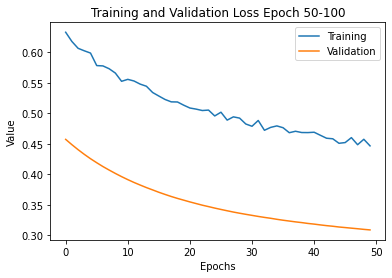

In [187]:
plot_train_and_validation_results(history_resnet_inception_50_to_100.history['loss'], history_resnet_inception_50_to_100.history['val_loss'], 'Training and Validation Loss Epoch 50-100', range(0, 51, 10))

As we can see the loss is still decreasing even at slower rate. The Accuracy and Top K Accuracy didn't improve much but the algorithm is definitely smarter now. It should be even more confident than before. Let's perform few real tests.

In [191]:
print(name_the_breed(image, resnet_inception, named_labels=named_labels))
print(name_the_breed(image2, resnet_inception, named_labels=named_labels))
print(name_the_breed(image3, resnet_inception, named_labels=named_labels))
print(name_the_breed(image4, resnet_inception, named_labels=named_labels))

This is a Yorkshire_terrier with 91.57 % certainty
This is a German_shepherd with 94.01 % certainty
This is a Tibetan_mastiff with 97.42 % certainty
This is a standard_poodle with 60.74 % certainty


Apart from the poodle which appears to be among the difficult breeds our model is quite confident in its judgement. Let's verify that with even more pictures!

In [192]:
image5 = imread('https://d2725vydq9j3xi.cloudfront.net/production/media/lawyer_ohara/images/ISS_0908_00279.0daf1c35.fill-847x400.jpg')

In [201]:
images = [imread('https://d2725vydq9j3xi.cloudfront.net/production/media/lawyer_ohara/images/ISS_0908_00279.0daf1c35.fill-847x400.jpg'),
          imread('https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/26155623/Siberian-Husky-standing-outdoors-in-the-winter.jpg'),
          imread('https://static.baubau.bg/thumbs/12/dakel.jpg'),
          imread('https://upload.wikimedia.org/wikipedia/commons/a/a0/000_American_Pit_Bull_Terrier.jpg'),
          imread('https://upload.wikimedia.org/wikipedia/commons/6/64/Hummel_Vedor_vd_Robandahoeve.jpg'),
          imread('https://s3-eu-west-1.amazonaws.com/w3.cdn.gpd/gb.pedigree.56/thumb_e6bfdad9-6951-407b-a11f-bbd0c25bd796.jpg'),
          imread('https://www.thesprucepets.com/thmb/X4Gs6Ct7szs4W3VFiJFHwQGLlmY=/2032x1143/smart/filters:no_upscale()/JasonNastaszewskiEyeEmBritishBulldog-772f3705fb164f5db16793aa44f5115f.jpg'),
          imread('https://porodi.net/wp-content/uploads/2020/05/15208189094_1b9e592d33_z.jpg'),
          imread('https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12225627/Pomeranian-On-White-01.jpg')]

In [202]:
def label_breeds(arr):
  for image in arr:
    plt.imshow(image)
    plt.show()
    print(name_the_breed(image, resnet_inception, named_labels=named_labels))

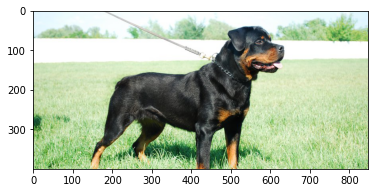

This is a Rottweiler with 97.93 % certainty


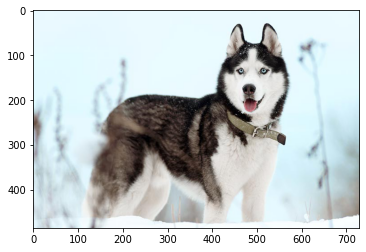

This is a Siberian_husky with 47.04 % certainty


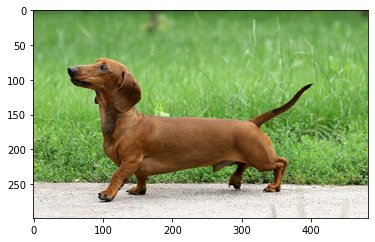

This is a vizsla with 65.87 % certainty


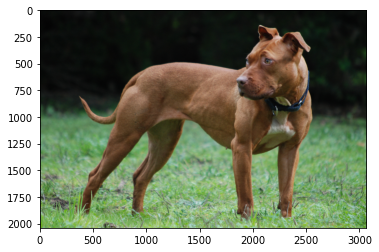

This is a American_Staffordshire_terrier with 76.76 % certainty


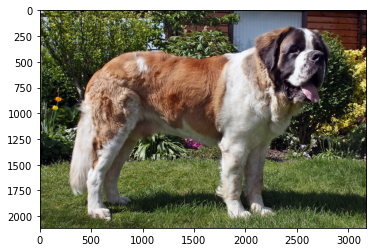

This is a Saint_Bernard with 97.73 % certainty


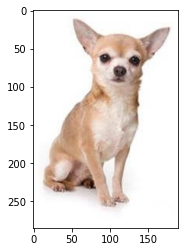

This is a Chihuahua with 92.93 % certainty


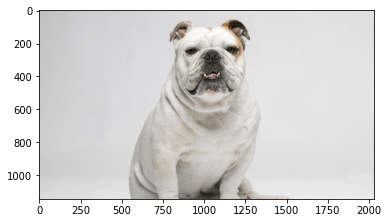

This is a pug with 74.39 % certainty


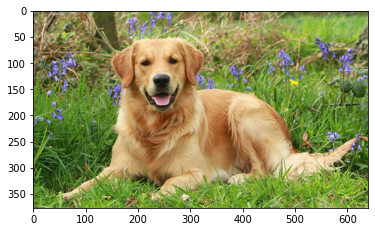

This is a golden_retriever with 94.5 % certainty


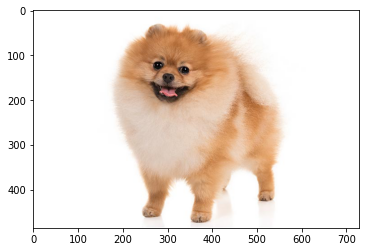

This is a Pomeranian with 98.02 % certainty


In [206]:
label_breeds(images)

I think the test went pretty well. It classified correctly 8/10 with high confidence and the ones he confused - dakel with vizsla and pure "bulldog", as I typed in google and took the first image, with pug are very much alike. Let's actually check the second and third choice, we've got almost 99% accuracy on Top 3 K labels, let's use it.

In [236]:
dakel = imread('https://static.baubau.bg/thumbs/12/dakel.jpg')
bulldog = imread('https://www.thesprucepets.com/thmb/X4Gs6Ct7szs4W3VFiJFHwQGLlmY=/2032x1143/smart/filters:no_upscale()/JasonNastaszewskiEyeEmBritishBulldog-772f3705fb164f5db16793aa44f5115f.jpg')


Here we've got different options how to decode predictions. We can either rewrite the class methods, retrain our models with different settings or simply be a little bit lazy  and deal with it smartly. We'll take the maximum one by one, then we will make the current maximum zero and go to the next. It's ugly but it's working so  why not.

In [240]:
def give_top_three_candidates(pic, model, named_labels=named_labels):
  picture = resize(pic, (299, 299), preserve_range = True)
  picture = tf.keras.applications.inception_resnet_v2.preprocess_input(picture)
  picture = tf.expand_dims(picture, axis = 0)
  predictions = model.predict(picture)
  score = ''
  prediction = max(predictions[0])
  index1 = list(predictions[0]).index(prediction)
  predictions[0][index1] = 0
  score += f'This is a {named_labels[index1]} with {round((100 * prediction), 2)} % certainty'
  score += '\n'
  prediction = max(predictions[0])
  index2 = list(predictions[0]).index(prediction)
  score += f'Second guess is {named_labels[index2]} with {round((100 * prediction), 2)} % certainty'
  score += "\n"
  predictions[0][index2] = 0
  prediction = max(predictions[0])
  index3 = list(predictions[0]).index(prediction)
  score += f'Third guess is {named_labels[index3]} with {round((100 * prediction), 2)} % certainty'
  return score

In [241]:
print(give_top_three_candidates(dakel, resnet_inception, named_labels=named_labels))

This is a vizsla with 65.87 % certainty
Second guess is redbone with 24.23 % certainty
Third guess is Rhodesian_ridgeback with 3.2 % certainty


In [242]:
print(give_top_three_candidates(bulldog, resnet_inception, named_labels=named_labels))

This is a pug with 74.39 % certainty
Second guess is bull_mastiff with 7.33 % certainty
Third guess is French_bulldog with 6.86 % certainty


After these two I got a little worried but quick check in named labels shows they are not even listed in this dataset. As I said, it's a tough one. 

In [245]:
named_labels.values()

dict_values(['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih_Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black_and_tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft', 'West_Highland_white_terrier', 'Lhasa', 'flat', 'curly', 'golden_retriever', 'Labrador_retriever', 

Let's now test our Top 3 Accuracy with some of the harder breeds. We'll choose those similar in looks or in names.

This is a Shih_Tzu with 57.67 % certainty
Second guess is Tibetan_terrier with 15.26 % certainty
Third guess is Lhasa with 11.49 % certainty


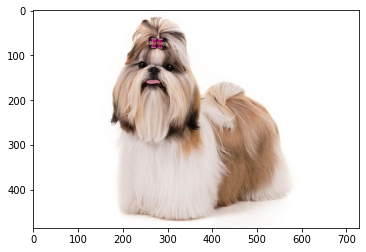

In [247]:
shih_tzu = imread('https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12224329/Shih-Tzu-On-White-01.jpg')
print(give_top_three_candidates(shih_tzu, resnet_inception, named_labels=named_labels))
plt.imshow(shih_tzu)
plt.show()

This is a Irish_terrier with 90.22 % certainty
Second guess is Lakeland_terrier with 0.94 % certainty
Third guess is Norfolk_terrier with 0.79 % certainty


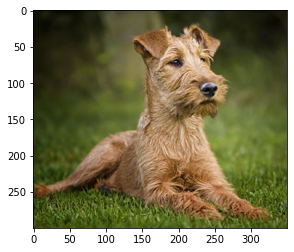

In [248]:
irish_terrier = imread('https://www.dogbreedplus.com/dog_breeds/images/irish_terrier.jpg')
print(give_top_three_candidates(irish_terrier, resnet_inception, named_labels=named_labels))
plt.imshow(irish_terrier)
plt.show()


This is a Labrador_retriever with 92.68 % certainty
Second guess is golden_retriever with 0.63 % certainty
Third guess is English_foxhound with 0.44 % certainty


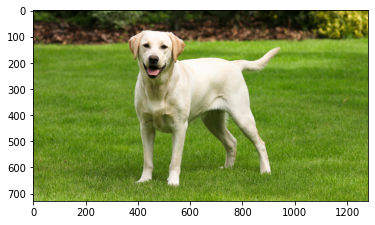

In [249]:
labrador_retriever = imread('https://cdn.orvis.com/images/DBS_Lab_1280.jpg')
print(give_top_three_candidates(labrador_retriever, resnet_inception, named_labels=named_labels))
plt.imshow(labrador_retriever)
plt.show()


This is a German_short with 96.35 % certainty
Second guess is bluetick with 0.38 % certainty
Third guess is English_springer with 0.23 % certainty


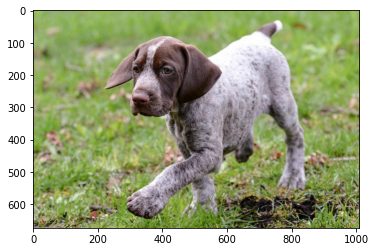

In [250]:
german_short = imread('https://i2.wp.com/alaskadogworks.com/wp-content/uploads/2020/02/germanshorthairedpointer_puppy.jpg?resize=1010%2C673&ssl=1')
print(give_top_three_candidates(german_short, resnet_inception, named_labels=named_labels))
plt.imshow(german_short)
plt.show()


## From training to debugging and detailed assessment 


With this final test we conclude the training process. It's definitely not the most representative one but we literally copied more than 20 random pictures from internet and our model classified all of them with two exceptions in dakel and "bulldog" that weren't even presented in the dataset it was trained on.

Now we are heading to debug the Neural Network in more details, get features, see where we did good and where we did poorly. 

At the end hopefully we will deploy the model, feed him with more data/breeds and make it even smarter and shinier.

In [254]:
#!mkdir -p saved_model
#resnet_inception.save(f'saved_model/resnet_inception') 

INFO:tensorflow:Assets written to: saved_model/resnet_inception/assets


INFO:tensorflow:Assets written to: saved_model/resnet_inception/assets


In [256]:
#!ls saved_model
#!ls saved_model/resnet_inception

resnet_inception
assets	saved_model.pb	variables


In [261]:
# test loading

#new_model = tf.keras.models.load_model('drive/MyDrive/saved_model/resnet_inception')


In [258]:
#new_model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
model_2 (Functional)         (None, 1536)              54336736  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               184440    
Total params: 54,521,176
Trainable params: 54,460,632
Non-trainable params: 60,544
_________________________________________________________________


## Sources:

1) http://vision.stanford.edu/aditya86/ImageNetDogs/ - dataset

2) https://www.angioi.com/dog-breed-classification/ - prepare and preprocess functions

3) https://keras.io/api/applications/inceptionresnetv2/ - base model - Inception-Resnet